# Data

## Data Sources
- [x] Home and rent prices - Zillow: https://www.zillow.com/research/data/
- [x] Demographics - ACS: https://www.census.gov/programs-surveys/acs
- [x] Crime - FBI: https://ucr.fbi.gov/crime-in-the-u.s
- [x] Unemployment - BLS: https://www.bls.gov/data/
- [ ] School ratings - GreatSchools: https://www.greatschools.org/
  - will need to scrape with selenium
- [ ] Public transportation - EPA: https://www.epa.gov/smartgrowth/smart-location-mapping
- [ ] Natural disasters - FEMA: https://www.fema.gov/data-feeds
- [ ] Distance to Disney World - Google Maps API: https://developers.google.com/maps/documentation

## Undocumented data sources
1. average size of home in sqft (probably Census)
2. PPI for maintenance expenses / average home expenses (probably BLS)

# Data Download

In [ ]:
import pandas as pd
import geopandas as gpd

# Read the Zillow CSV file into a pandas DataFrame
zillow = pd.read_csv("https://files.zillowstatic.com/research/public_csvs/zhvi/Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1742438344")

# Filter only the data for the city of Orlando, FL
orlando_zillow = zillow[zillow['City'] == 'Orlando']

# Remove all columns except for the RegionID, RegionName, and columns for years
orlando_zillow = orlando_zillow.drop(columns=['RegionType', 'RegionID', 'State', 'StateName', 'SizeRank', 'City', 'Metro', 'CountyName', 'RegionID', 'SizeRank'])

# Load a GeoJSON file containing the geographical boundaries of Orlando neighborhoods
url = "https://raw.githubusercontent.com/blackmad/neighborhoods/refs/heads/master/orlando.geojson"
orlando_geo = gpd.read_file(url)

# Exploratory Analysis

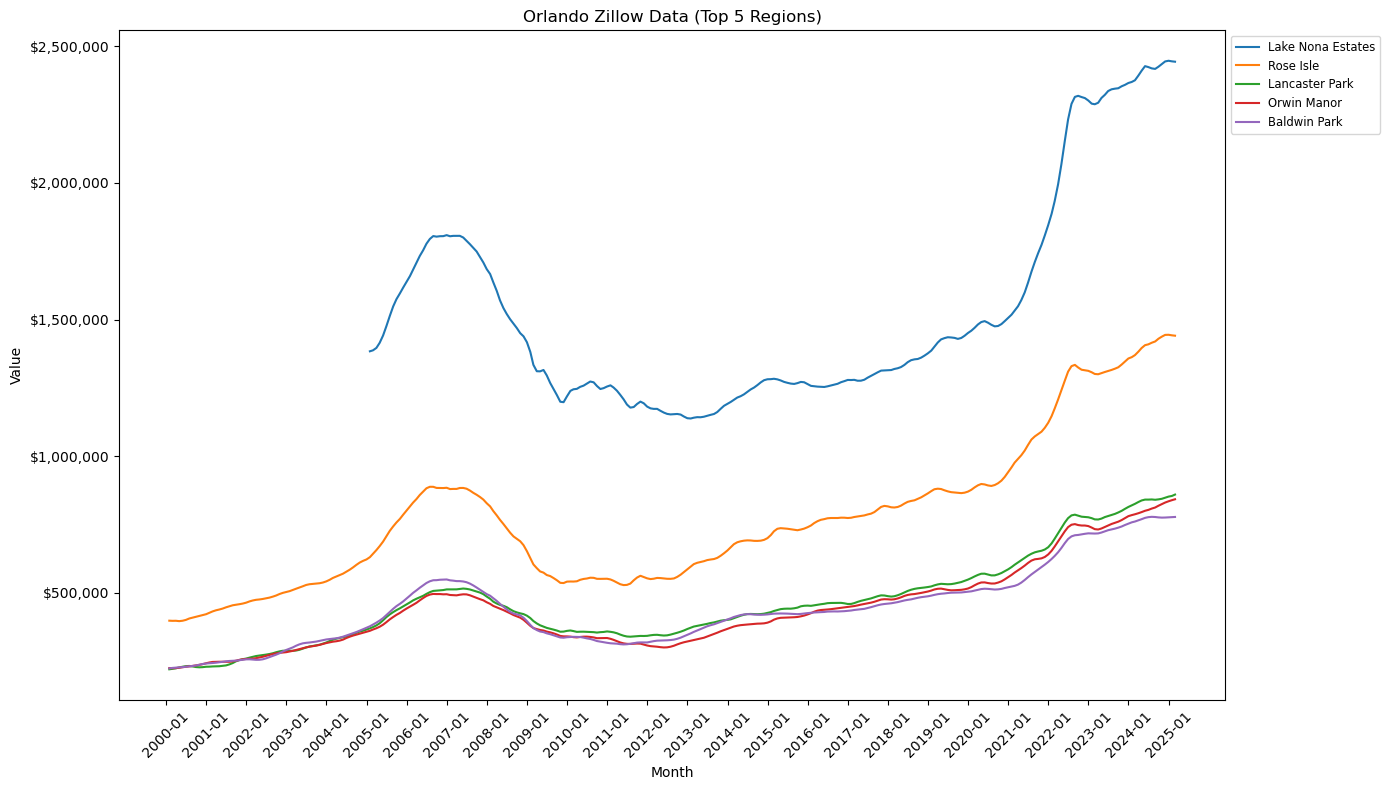

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Convert the wide format data into a long format
orlando_zillow_long = orlando_zillow.melt(id_vars=['RegionName'], var_name='month', value_name='value')
orlando_zillow_long['month'] = pd.to_datetime(orlando_zillow_long['month'])

# Calculate the median 2024 home prices for each neighborhood
median_2024_prices = orlando_zillow_long[orlando_zillow_long['month'].dt.year == 2024].groupby('RegionName')['value'].median()

# Get the top 5 neighborhoods with the highest median 2024 home prices
top_5_neighborhoods = median_2024_prices.nlargest(5).index

# Filter the data for these top 5 neighborhoods
filtered_data = orlando_zillow_long[orlando_zillow_long['RegionName'].isin(top_5_neighborhoods)]

# Plot the data
plt.figure(figsize=(14, 8))  # Expand the size of the plot
for neighborhood in top_5_neighborhoods:
  neighborhood_data = filtered_data[filtered_data['RegionName'] == neighborhood]
  plt.plot(neighborhood_data['month'], neighborhood_data['value'], label=neighborhood)

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Orlando Zillow Data (Top 5 Regions)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='small')

# Format y-axis as US dollars
formatter = ticker.FuncFormatter(lambda x, _: f'${x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

# Show only the first month of each year on the x-axis
unique_months = orlando_zillow_long['month'].dt.to_period('M').drop_duplicates().dt.to_timestamp()
yearly_months = unique_months[unique_months.dt.month == 1]
plt.xticks(
  ticks=yearly_months,
  labels=yearly_months.dt.strftime('%Y-%m'),
  rotation=45
)

plt.tight_layout()
plt.show()

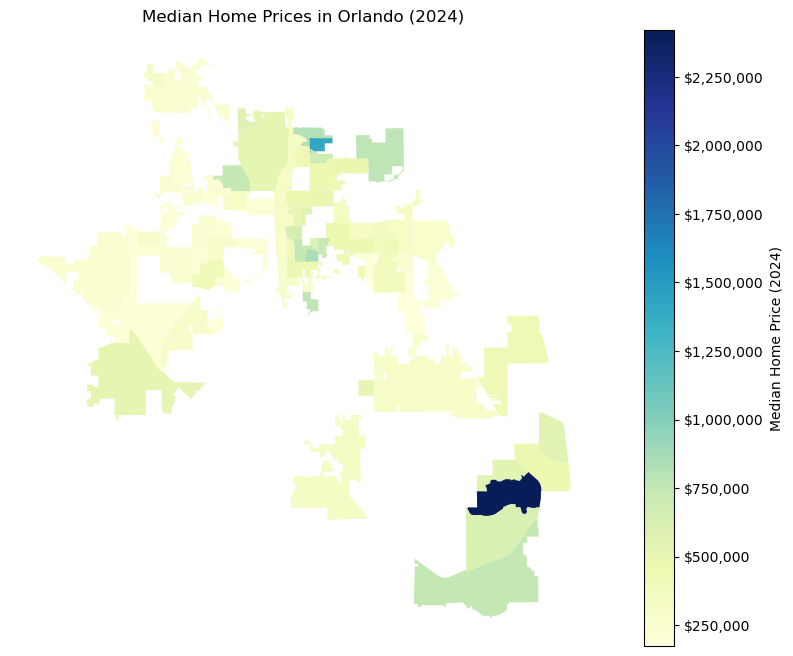

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Calculate the median home price for each region in 2024
orlando_zillow_long['year'] = pd.to_datetime(orlando_zillow_long['month']).dt.year
median_prices_2024 = orlando_zillow_long[orlando_zillow_long['year'] == 2024].groupby('RegionName')['value'].median()

# Merge the median prices with the GeoDataFrame
orlando_geo = orlando_geo.merge(median_prices_2024, left_on='name', right_index=True, how='left')

# Plot the chloropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
orlando_geo.plot(column='value', cmap='YlGnBu', legend=True, legend_kwds={'label': "Median Home Price (2024)"}, ax=ax)

# Format the legend to display in USD
formatter = FuncFormatter(lambda x, _: f'${x:,.0f}')
colorbar = ax.get_figure().axes[-1]  # Get the colorbar axis
colorbar.yaxis.set_major_formatter(formatter)

plt.title("Median Home Prices in Orlando (2024)")
plt.axis('off')
plt.show()

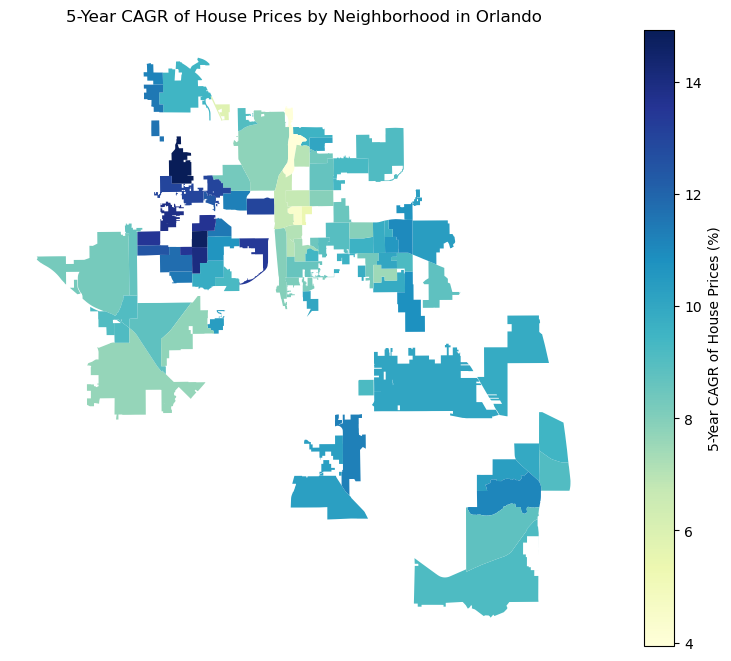

In [91]:
# Calculate the 5-year CAGR for each neighborhood
def calculate_cagr(start_value, end_value, years):
  if pd.isna(start_value) or pd.isna(end_value) or start_value <= 0:
    return None
  return ((end_value / start_value) ** (1 / years)) - 1

# Filter data for the last 5 years
orlando_zillow_long['year'] = orlando_zillow_long['month'].dt.year
end_year = orlando_zillow_long['year'].max() - 1
start_year = end_year - 5

cagr_data = orlando_zillow_long[orlando_zillow_long['year'].isin([start_year, end_year])]

# Calculate the average 'value' for each year and each RegionName
cagr_data = cagr_data.groupby(['RegionName', 'year'])['value'].mean().unstack()

# Ensure that both start_year and end_year exist in the data
cagr_data = cagr_data[[start_year, end_year]].dropna()

# Calculate the 2020-2025 CAGR for each region
cagr_data['CAGR'] = cagr_data.apply(lambda row: calculate_cagr(row[start_year], row[end_year], end_year - start_year), axis=1)

# Convert CAGR values to percentages
cagr_data['CAGR'] = cagr_data['CAGR'] * 100

# Merge the CAGR data with the GeoDataFrame
cagr_geo = orlando_geo.merge(cagr_data[['CAGR']], left_on='name', right_index=True, how='left')

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cagr_geo.plot(
  column='CAGR',
  cmap='YlGnBu',
  legend=True,
  legend_kwds={'label': "5-Year CAGR of House Prices (%)", 'fmt': '%.2f%%'},
  ax=ax
)

# Customize the plot
plt.title("5-Year CAGR of House Prices by Neighborhood in Orlando")
plt.axis('off')
plt.show()

In [39]:
from dotenv import load_dotenv
import os
from census import Census
from us import states

c = Census(os.getenv("CENSUS_API"))

orlando_income_all_years = []

for year in range(2009, 2022):
  orlando_income = c.acs5.state_county_tract(('NAME', 'B19013_001E'),
                         states.FL.fips,
                         county_fips='095',
                         tract='*',
                         year=year)
  orlando_income_df = pd.DataFrame(orlando_income)
  orlando_income_df['tract'] = orlando_income_df['tract'].astype(int)
  orlando_income_df['median_income'] = orlando_income_df['B19013_001E']
  orlando_income_df = orlando_income_df[['tract', 'median_income']]
  orlando_income_df['tract'] = orlando_income_df['tract'].astype(str).str.zfill(6)
  orlando_income_df['year'] = year
  orlando_income_all_years.append(orlando_income_df)

orlando_income_all_years_df = pd.concat(orlando_income_all_years, ignore_index=True)

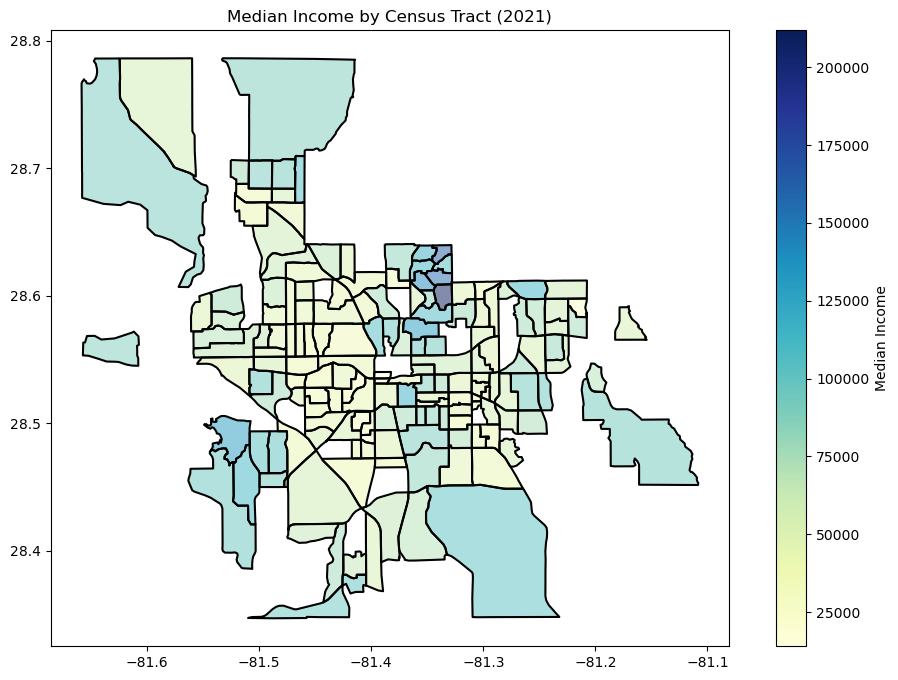

In [117]:
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

# Get the notebook path
workspace_path = os.getenv("WORKSPACE_PATH")

gdf = gpd.read_file(workspace_path + '/data/cb_2018_12_tract_500k.shp')
gdf = gdf[gdf['COUNTYFP'] == '095']

# Ensure both GeoDataFrames have the same CRS (Coordinate Reference System)
gdf = gdf.to_crs(orlando_geo.crs)

income_gdf = gdf.merge(orlando_income_all_years_df, left_on='TRACTCE', right_on='tract')
income_gdf = income_gdf[income_gdf['tract'] != '990000']

# plot the median income for 2021
# Filter the data for the year 2021
gdf_2021 = income_gdf[income_gdf['year'] == 2021]

# Plot the median income for 2021
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_2021.boundary.plot(ax=ax, color='black')  # Show the borders for each census tract
gdf_2021.plot(column='median_income', cmap='YlGnBu', legend=True, legend_kwds={'label': "Median Income"}, ax=ax, alpha=0.5)
plt.title("Median Income by Census Tract (2021)")
plt.show()

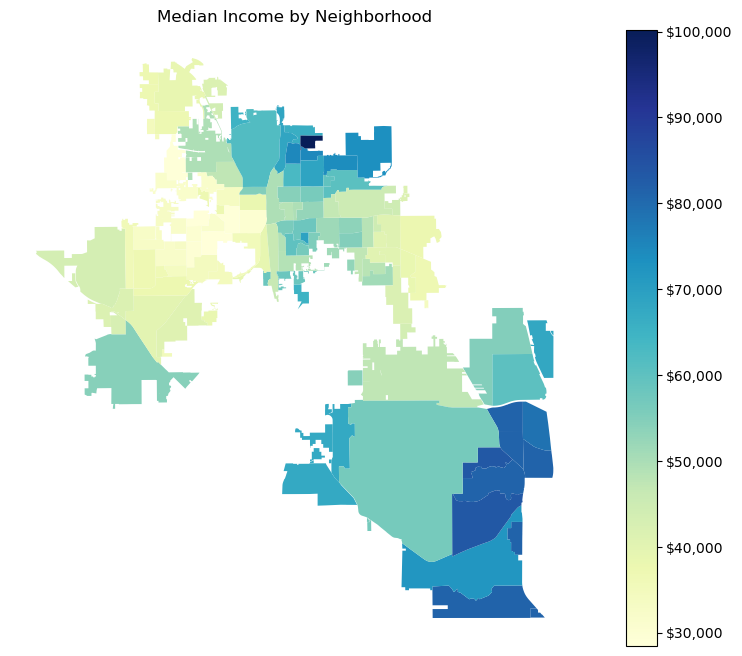

In [111]:
from matplotlib.ticker import FuncFormatter


# Perform a spatial join to map census tract data to neighborhoods
mapped_data = gpd.sjoin(income_gdf, orlando_geo, how="inner", predicate="intersects")

# Group by neighborhood and calculate the average median income for each neighborhood
neighborhood_income = mapped_data.groupby('name')['median_income'].mean().reset_index()

# Merge the calculated neighborhood income back into the orlando_geo GeoDataFrame
income_geo = orlando_geo.merge(neighborhood_income, left_on='name', right_on='name', how='left')

# Plot the updated GeoDataFrame with median income
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
income_geo.plot(column='median_income', cmap='YlGnBu', legend=True, ax=ax)

# Format the legend to display in USD
formatter = FuncFormatter(lambda x, _: f'${x:,.0f}')
colorbar = ax.get_figure().axes[-1]  # Get the colorbar axis
colorbar.yaxis.set_major_formatter(formatter)

plt.title("Median Income by Neighborhood")
plt.axis('off')
plt.show()

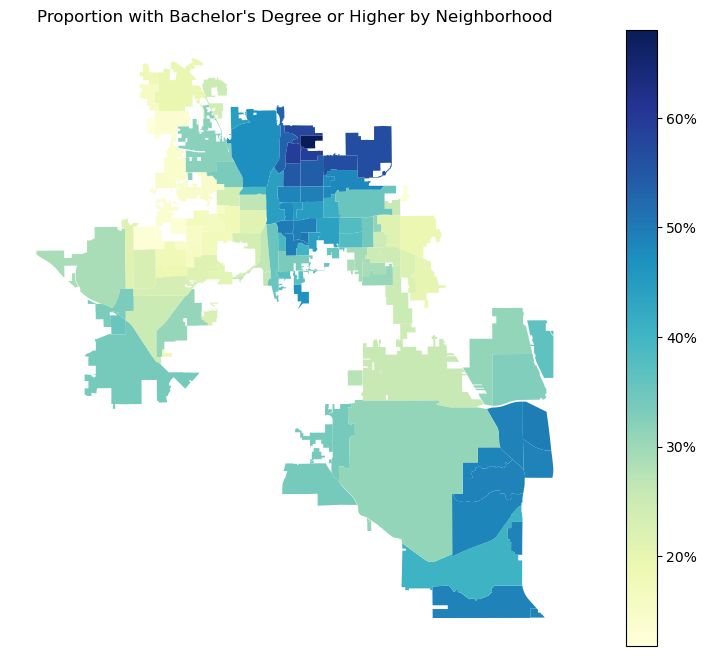

In [ ]:
# Pull data for the proportion of individuals with at least a bachelor's degree
unemployment_data_all_years = []

for year in range(2010, 2023):
  unemployment_data = c.acs5.state_county_tract(('NAME', 'B06009_001E', 'B06009_005E', 'B06009_006E'),
                         states.FL.fips,
                         county_fips='095',
                         tract='*',
                         year=year)
  unemployment_df = pd.DataFrame(unemployment_data)
  unemployment_df['tract'] = unemployment_df['tract'].astype(int)
  unemployment_df['bach'] = (unemployment_df['B06009_005E'] + unemployment_df['B06009_006E']) / unemployment_df['B06009_001E']
  unemployment_df = unemployment_df[['tract', 'bach']]
  unemployment_df['tract'] = unemployment_df['tract'].astype(str).str.zfill(6)
  unemployment_df['year'] = year
  unemployment_data_all_years.append(unemployment_df)

unemployment_df = pd.concat(unemployment_data_all_years, ignore_index=True)

unemployment_gdf = gdf.merge(unemployment_df, left_on='TRACTCE', right_on='tract')
unemployment_gdf = unemployment_gdf[unemployment_gdf['tract'] != '990000']
unemployment_mapped_data = gpd.sjoin(unemployment_gdf, orlando_geo, how="inner", predicate="intersects")

# Group by neighborhood and calculate the average median income for each neighborhood
neighborhood_unemployment = unemployment_mapped_data.groupby('name')['bach'].mean().reset_index()

# Merge the calculated neighborhood income back into the orlando_geo GeoDataFrame
unemployment_geo = orlando_geo.merge(neighborhood_unemployment, left_on='name', right_on='name', how='left')

# Plot the updated GeoDataFrame with median income
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
unemployment_geo.plot(column='bach', cmap='YlGnBu', legend=True, ax=ax)

# Format the legend to display in USD
formatter = FuncFormatter(lambda x, _: f'{x:.0%}')
colorbar = ax.get_figure().axes[-1]  # Get the colorbar axis
colorbar.yaxis.set_major_formatter(formatter)

plt.title("Proportion with Bachelor's Degree or Higher by Neighborhood")
plt.axis('off')
plt.show()

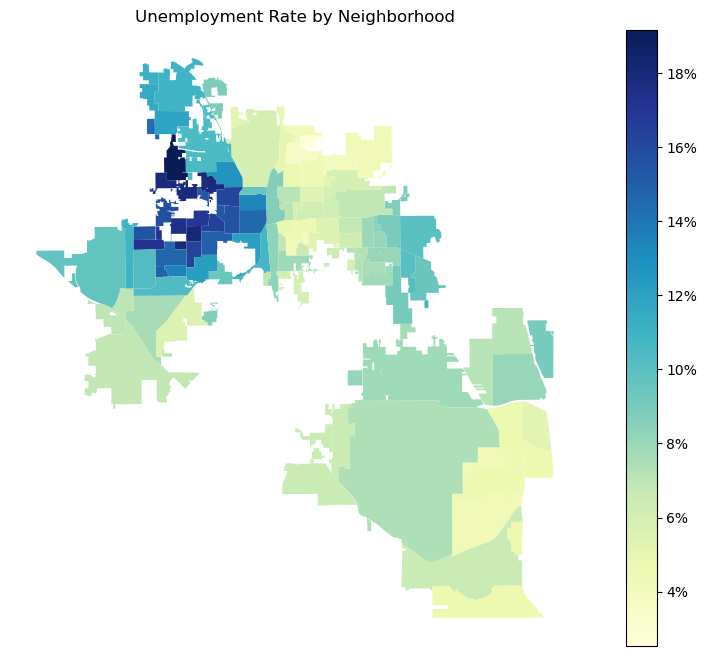

In [125]:
# Pull data for the proportion of individuals with at least a bachelor's degree
unemployment_data = []

for year in range(2011, 2023):
    # Fetch data from the API
    data = c.acs5.state_county_tract(
        ('NAME', 'B23025_003E', 'B23025_005E'),
        states.FL.fips,
        county_fips='095',
        tract='*',
        year=year
    )
    
    # Convert the data to a DataFrame
    unemployment_df = pd.DataFrame(data)
    unemployment_df['tract'] = unemployment_df['tract'].astype(int)
    unemployment_df['unemployment'] = unemployment_df['B23025_005E'] / unemployment_df['B23025_003E']
    unemployment_df = unemployment_df[['tract', 'unemployment']]
    unemployment_df['tract'] = unemployment_df['tract'].astype(str).str.zfill(6)
    unemployment_df['year'] = year
    
    # Append the DataFrame to the list
    unemployment_data.append(unemployment_df)

# Concatenate all DataFrames in the list into a single DataFrame
unemployment_dataframe = pd.concat(unemployment_data, ignore_index=True)

# Merge with the GeoDataFrame
unemployment_gdf = gdf.merge(unemployment_dataframe, left_on='TRACTCE', right_on='tract')
unemployment_gdf = unemployment_gdf[unemployment_gdf['tract'] != '990000']
unemployment_mapped_data = gpd.sjoin(unemployment_gdf, orlando_geo, how="inner", predicate="intersects")

# Group by neighborhood and calculate the average unemployment rate for each neighborhood
neighborhood_unemployment = unemployment_mapped_data.groupby('name')['unemployment'].mean().reset_index()

# Merge the calculated neighborhood unemployment back into the orlando_geo GeoDataFrame
unemployment_geo = orlando_geo.merge(neighborhood_unemployment, left_on='name', right_on='name', how='left')

# Plot the updated GeoDataFrame with unemployment rate
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
unemployment_geo.plot(column='unemployment', cmap='YlGnBu', legend=True, ax=ax)

# Format the legend to display as percentages
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, _: f'{x:.0%}')
colorbar = ax.get_figure().axes[-1]  # Get the colorbar axis
colorbar.yaxis.set_major_formatter(formatter)

plt.title("Unemployment Rate by Neighborhood")
plt.axis('off')
plt.show()

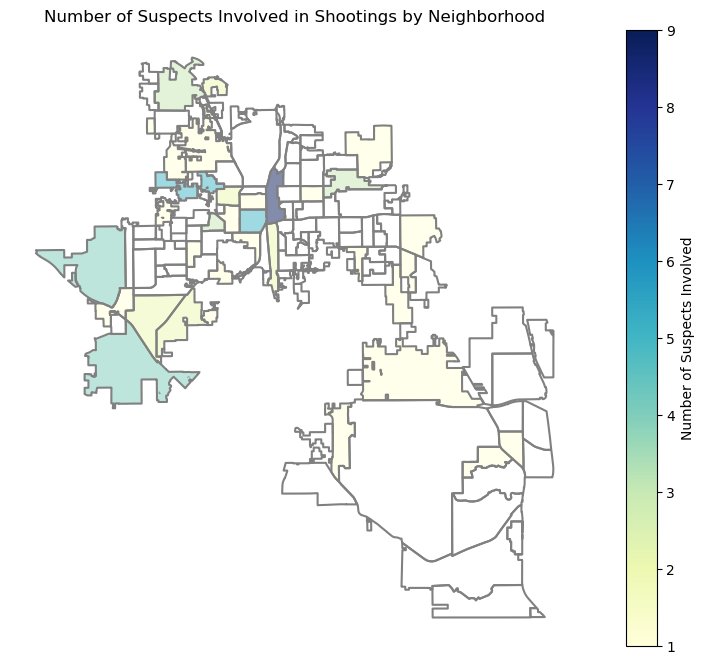

In [156]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the officer-involved shootings GeoJSON data
url = "https://data.cityoforlando.net/resource/6kz6-6c7n.geojson"
officer_geo = gpd.read_file(url)

# Ensure both GeoDataFrames have the same CRS (Coordinate Reference System)
officer_geo = officer_geo.to_crs(orlando_geo.crs)

# Perform a spatial join to map shootings data to neighborhoods
officer_geo = gpd.sjoin(officer_geo, orlando_geo, how="inner", predicate="intersects")

# Ensure the type of 'number_of_suspects_involved' is integer
officer_geo['number_of_suspects_involved'] = officer_geo['number_of_suspects_involved'].fillna(0).astype(int)

# Group by neighborhood and calculate the total number of suspects involved in each neighborhood
officer_geo = officer_geo.groupby('name')['number_of_suspects_involved'].sum().reset_index()

# Merge the calculated data back into the orlando_geo GeoDataFrame
officer_geo = orlando_geo.merge(officer_geo, left_on='name', right_on='name', how='left')

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
officer_geo.boundary.plot(ax=ax, color='gray')  # Show the borders for each neighborhood
officer_geo.plot(
  column='number_of_suspects_involved',
  cmap='YlGnBu',
  legend=True,
  legend_kwds={'label': "Number of Suspects Involved"},
  ax=ax,
  alpha=0.5
)

# Customize the plot
plt.title("Number of Suspects Involved in Shootings by Neighborhood")
plt.axis('off')
plt.show()